In [1]:
import sys
sys.path.insert(0,'/Users/nakaa1/code/py/PsychRNN')

import psychrnn
from psychrnn.tasks import rdm as rd
from psychrnn.backend.models.basic import Basic, BasicSigmoid
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
import importlib
importlib.reload(psychrnn)

<module 'psychrnn' from '/Users/nakaa1/code/py/PsychRNN/psychrnn/__init__.py'>

define params globally first before passing to RDM, mess w/ model params and explain what can do. (can turn on and off dale's law). some masking, input output connectivity. train_params variables stuff

In [2]:
dt = 10 # time-step
tau = 100 # intrinsic time constant of neural state decay
T = 2000 # time to run for (number of steps is T/dt)
N_batch = 50 # number of trials per training step
N_rec = 100 # number of recurrent units
name = 'basicModel'

In [118]:
from psychrnn.tasks.task import Task


"""
Binary Decision task. 
Takes two channels of noisy input.
Binary output with a one hot encoding towards the higher mean channel
"""
class sinewave(Task):
    def __init__(self, dt, tau, T, N_batch):
        super(sinewave,self).__init__(1, 1, dt, tau, T, N_batch)
                                    #N_in, N_out
    def generate_trial_params(self, batch, trial):

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['choice'] = np.random.choice([0,1,2])
        freqs = [0.03,0.03,0.03]
        params['freq'] = freqs[params['choice']]
        params['onset_time'] = np.random.random() * self.T / 8.0
        params['stim_duration'] = np.random.random() * self.T *10
        return params

    def trial_function(self, t, params):

        # ----------------------------------
        # Initialize with noise
        # ----------------------------------
        x_t = np.zeros(self.N_in)
        y_t = np.zeros(self.N_out)
        mask_t = np.ones(self.N_out)

        # ----------------------------------
        # Retrieve parameters
        # ----------------------------------
        freq = params['freq']
        onset = params['onset_time']
        stim_dur = params['stim_duration']

        # ----------------------------------
        # Compute values
        # ----------------------------------
        x_t = np.sin(t * params['freq']) 

        y_t = np.sin(t * params['freq']) 

        if t < onset + stim_dur:
            mask_t = np.zeros(self.N_out)

        return x_t, y_t, mask_t

        return x_t, y_t, mask_t
    
    
class noisy_decode(Task):
    def __init__(self, dt, tau, T, N_batch):
        super(noisy_decode,self).__init__(1, 1, dt, tau, T, N_batch)
                                    #N_in, N_out
    def generate_trial_params(self, batch, trial):

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['choice'] = np.random.choice([0,1,2,3,4,5])
        rates = [10,11,12,13,14,15]
        params['rate'] = rates[params['choice']]
        return params

    def trial_function(self, t, params):

        # ----------------------------------
        # Initialize with noise
        # ----------------------------------
        x_t = np.zeros(self.N_in)
        y_t = np.zeros(self.N_out)
        mask_t = np.ones(self.N_out)

        # ----------------------------------
        # Retrieve parameters
        # ----------------------------------
        rate = params['rate']
        

        # ----------------------------------
        # Compute values
        # ----------------------------------
        x_t = np.random.randn()*3+ params['rate']

        y_t = params['rate']

        

        return x_t, y_t, mask_t

        return x_t, y_t, mask_t
    
    
class many2one_noisy_decode(Task):
    def __init__(self, dt, tau, T, N_batch):
        super(many2one_noisy_decode,self).__init__(10, 1, dt, tau, T, N_batch)
                                    #N_in, N_out
    def generate_trial_params(self, batch, trial):

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['rate'] = np.random.randn()*3+10
        params['neuron_noise'] = np.random.choice([0,1,2,3])
        params['rate_noise'] = np.random.choice([0,1,2,3])
        return params

    def trial_function(self, t, params):

        # ----------------------------------
        # Initialize with noise
        # ----------------------------------
        x_t = np.zeros(self.N_in)
        y_t = np.zeros(self.N_out)
        mask_t = np.ones(self.N_out)

        # ----------------------------------
        # Retrieve parameters
        # ----------------------------------
        rate = params['rate']
        

        # ----------------------------------
        # Compute values
        # ----------------------------------

        x_t = np.random.randn(N_in)*params+ params['rate']

        y_t = params['rate']

        

        return x_t, y_t, mask_t

        return x_t, y_t, mask_t

In [92]:
swv = sinewave(dt = dt, tau = tau, T = T, N_batch = N_batch)
gen = swv.batch_generator()

In [130]:
tsk = noisy_decode(dt = dt, tau = tau, T = T, N_batch = N_batch)
gen = tsk.batch_generator()

In [131]:
params = tsk.__dict__
print(params)

{'N_batch': 50, 'N_in': 1, 'N_out': 1, 'dt': 10, 'tau': 100, 'T': 2000, 'alpha': 0.1, 'N_steps': 200}


Generate *N_batch* trials to be used in training

We add in a few params that Basic(RNN) needs but that RDM doesn't generate for us.

In [132]:
params['name'] = name #Used to scope out a namespace for global variables.
params['N_rec'] = N_rec

There are some other optional parameters we can add in:

In [133]:
params['dale_ratio'] = None # Default: None -- when the dale_ratio is set, dale's law is applied
params['rec_noise'] = 0.0 # Default: 0.0 -- how much noise to add to the new_state calculation
params['W_in_train'] = True # Indicates whether W_in is trainable. Default: True
params['W_rec_train'] = True # Indicates whether W_rec is trainable. Default: True
params['W_out_train'] = True # Indicates whether W_out is trainable. Default: True
params['b_rec_train'] = True # Indicates whether b_rec is trainable. Default: True
params['b_out_train'] = True # Indicates whether b_out is trainable. Default: True
params['init_state_train'] = True # Indicates whether init_state is trainable. Default: True
params['load_weights_path'] = None # When given a path, loads weights from file in that path. Default: None
params['L2_out'] = 0

Instantiate our model

In [134]:
basicModel.destruct()

In [135]:
basicModel = Basic(params)

Start a tensorflow session with loss, regularization, predictions, and regularized loss defined.

In [136]:
basicModel.build()

Set the training parameters for our model. All of the parameters below are optional.

In [137]:
train_params = {}
train_params['save_weights_path'] =  '../weights/refactor_weights.npz' # Where to save the model after training. Default: None
train_params['training_iters'] = 10000 # number of iterations to train for Default: 10000
train_params['learning_rate'] = .001 # Sets learning rate if use default optimizer Default: .001
train_params['loss_epoch'] = 10 # Compute and record loss every 'loss_epoch' epochs. Default: 10
train_params['verbosity'] = True # If true, prints information as training progresses. Default: True
train_params['save_training_weights_epoch'] = 100 # save training weights every 'save_training_weights_epoch' epochs. Default: 100
train_params['training_weights_path'] = None # where to save training weights as training progresses. Default: None
train_params['generator_function'] = None # replaces trial_batch_generator with the generator_function when not none. Default: None
train_params['optimizer'] = tf.train.AdamOptimizer(learning_rate=train_params['learning_rate']) # What optimizer to use to compute gradients. Default: tf.train.AdamOptimizer(learning_rate=train_params['learning_rate'])
train_params['clip_grads'] = True # If true, clip gradients by norm 1. Default: True

In [138]:
train_params

{'save_weights_path': '../weights/refactor_weights.npz',
 'training_iters': 10000,
 'learning_rate': 0.001,
 'loss_epoch': 10,
 'verbosity': True,
 'save_training_weights_epoch': 100,
 'training_weights_path': None,
 'generator_function': None,
 'optimizer': <tensorflow.python.training.adam.AdamOptimizer at 0x1a9267fd0>,
 'clip_grads': True}

Train our model.

In [139]:
basicModel.train(gen, train_params)

Iter 500, Minibatch Loss= 101.306046
Iter 1000, Minibatch Loss= 87.013535
Iter 1500, Minibatch Loss= 26.358490
Iter 2000, Minibatch Loss= 17.759918
Iter 2500, Minibatch Loss= 10.280129
Iter 3000, Minibatch Loss= 9.679141
Iter 3500, Minibatch Loss= 6.142443
Iter 4000, Minibatch Loss= 5.710996
Iter 4500, Minibatch Loss= 5.383883
Iter 5000, Minibatch Loss= 3.765890
Training weights saved in file: None100
Iter 5500, Minibatch Loss= 3.252282
Iter 6000, Minibatch Loss= 4.421055
Iter 6500, Minibatch Loss= 2.657529
Iter 7000, Minibatch Loss= 2.402243
Iter 7500, Minibatch Loss= 3.946777
Iter 8000, Minibatch Loss= 2.094603
Iter 8500, Minibatch Loss= 2.025302
Iter 9000, Minibatch Loss= 2.133550
Iter 9500, Minibatch Loss= 1.691504
Optimization finished!
Model saved in file: ../weights/refactor_weights.npz


([101.306046,
  87.013535,
  26.35849,
  17.759918,
  10.280129,
  9.679141,
  6.142443,
  5.710996,
  5.383883,
  3.76589,
  3.2522824,
  4.4210553,
  2.6575289,
  2.402243,
  3.9467766,
  2.094603,
  2.025302,
  2.1335502,
  1.6915045],
 106.19619297981262,
 19.96959114074707)

### Plot results

Extract the next trial from the generator

Run the trained model on this trial (not included in the training set).

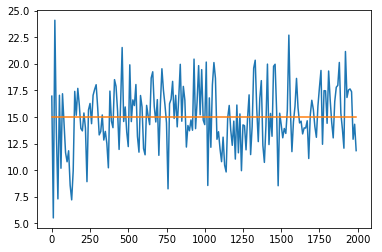

In [145]:
x,y,m = next(gen)
plt.plot(range(0, len(x[0,:,:])*dt,dt), x[0,:,:])
plt.plot(range(0, len(y[0,:,:])*dt,dt), y[0,:,:])

In [146]:
results = basicModel.test(x)
output = results[0]
state_var = results[1]

Text(0.5, 1.0, 'Output on New Sample')

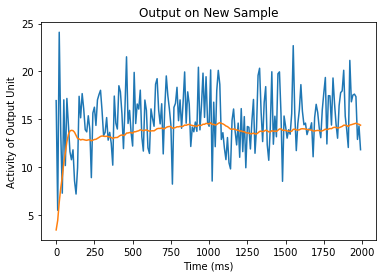

In [147]:
plt.plot(range(0, len(x[0,:,:])*dt,dt),x[0,:,:])
plt.plot(range(0, len(output[0,:,:])*dt,dt),output[0,:,:])
plt.ylabel("Activity of Output Unit")
plt.xlabel("Time (ms)")
plt.title("Output on New Sample")

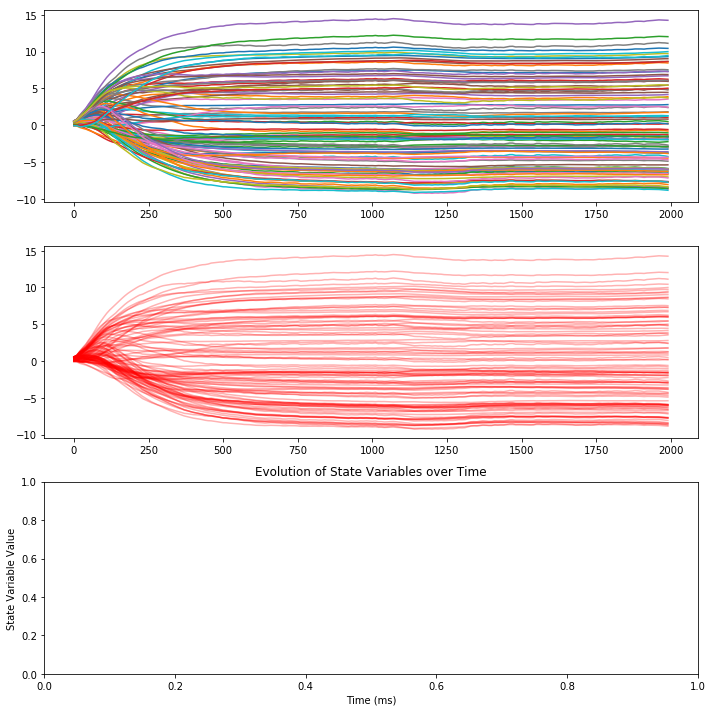

In [148]:
weights = basicModel.get_weights()
E = np.diag(weights['Dale_rec'])>0
I = np.diag(weights['Dale_rec'])<0

f,ax = plt.subplots(3,1,figsize = (10,10))

ax[0].plot(range(0, len(state_var[0,:,:])*dt,dt),state_var[0,:,:])
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.title("Evolution of State Variables over Time")

for ind in np.where(E)[0]:
    ax[1].plot(range(0, len(state_var[0,:,ind])*dt,dt),state_var[0,:,ind],'r',alpha = 0.3)
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")

for ind in np.where(I)[0]:
    ax[2].plot(range(0, len(state_var[0,:,ind])*dt,dt),state_var[0,:,ind],'b',alpha = 0.3)
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.tight_layout()

In [160]:
peak_times_first_cycle = np.argmax(state_var[0,:50,:],axis =0)

In [159]:
state_var.shape

(50, 200, 40)

In [161]:
peak_times_first_cycle

array([18, 15, 21, 22, 11, 22, 15, 16, 12, 16,  9, 15, 18, 14, 13, 16, 17,
       18, 16, 15, 15, 17, 18, 18, 20, 19, 19, 16, 24, 19,  3, 22,  3, 19,
       21, 21, 22, 20, 20, 22])

In [162]:
np.sort(peak_times_first_cycle)

array([ 3,  3,  9, 11, 12, 13, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16,
       17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 21, 21, 21,
       22, 22, 22, 22, 22, 24])

In [163]:
peak_order = np.argsort(peak_times_first_cycle)

In [164]:
peak_order

array([32, 30, 10,  4,  8, 14, 13, 11, 19,  6,  1, 20,  9, 27, 15, 18,  7,
       21, 16, 23, 22,  0, 17, 12, 25, 26, 29, 33, 24, 37, 38, 35,  2, 34,
       36,  3,  5, 31, 39, 28])

In [170]:
sort_state = np.zeros(state_var.shape)
for trial in range(state_var.shape[0]):
    for i,this_neuron in enumerate(peak_order):
        sort_state[trial,:,i] = state_var[trial,:,this_neuron]

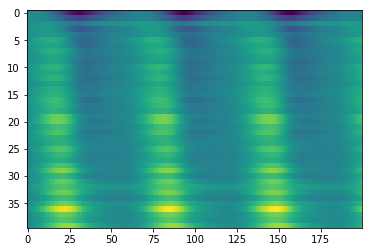

In [173]:
plt.imshow(sort_state[1,:,:].T,aspect = 'auto')

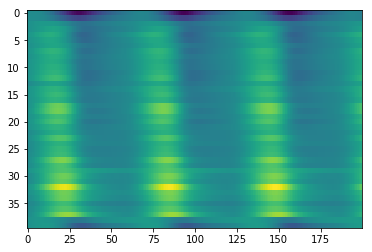

In [158]:
plt.imshow(state_var[0,:,peak_order],aspect = 'auto')

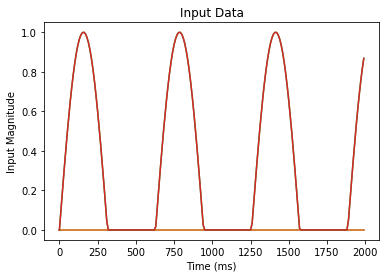

In [132]:
plt.plot(range(0, len(x[0,:,:])*dt,dt), x[0,:,:])
plt.ylabel("Input Magnitude")
plt.xlabel("Time (ms)")
plt.title("Input Data")
plt.plot(range(0, len(y[0,:,:])*dt,dt), y[0,:,:])

In [179]:
weights = basicModel.get_weights()
E = np.diag(weights['Dale_rec'])>0
I = np.diag(weights['Dale_rec'])<0

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.], dtype=float32)

In [44]:
weights['input_connectivity'].shape

(50, 2)

In [45]:
weights.keys()
toplot = ['W_in', 'W_rec', 
 'W_out','Dale_rec', 
 'Dale_out', 'input_connectivity', 
 'rec_connectivity', 'output_connectivity']

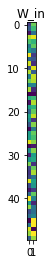

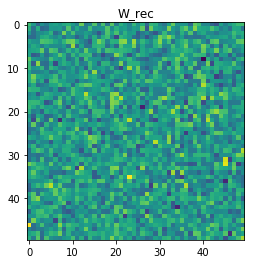

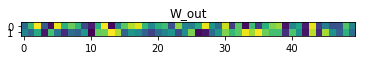

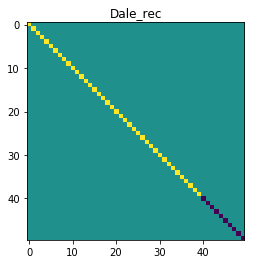

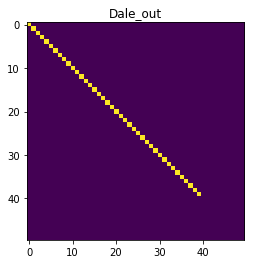

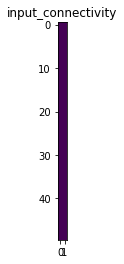

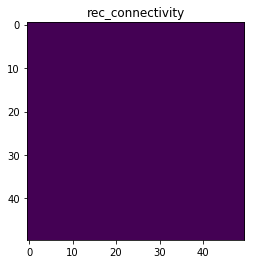

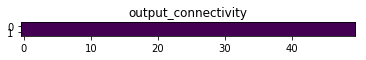

In [58]:
for key in toplot:
    plt.figure()
    plt.imshow(weights[key])
    plt.title(key)

Text(0.5, 1.0, 'Output on New Sample')

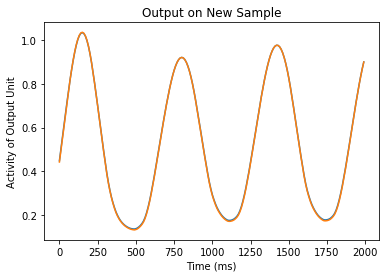

In [63]:
N_rec = 10
dale_ratio = 0.8

In [64]:
dale_vec = np.ones(N_rec)
        
dale_vec[int(dale_ratio * N_rec):] = -1
dale_rec = np.diag(dale_vec)
dale_vec[int(dale_ratio * N_rec):] = 0
dale_out = np.diag(dale_vec)

In [65]:
dale_rec

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])

Text(0.5, 1.0, 'Evolution of State Variables over Time')

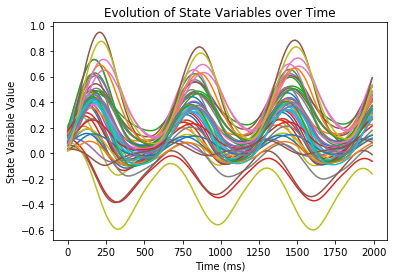

Clean up the model to clear out the tensorflow namespace

In [76]:
basicModel.destruct()